In [6]:
# utilities
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import math

In [7]:
# Constants
k01_100 = 5.25E-5   # L/mol/s
Ea1 = 57000   # J/mol
H1 = -10000   # Reaction enthalpy J/mol
k02_100 = 7E-8  
Ea2 = 220000 
H2 = -95000 
k03_100 = 0.3E-8  
Ea3 = 250000 
H3 = -5000
Rg = 8.314   # J/mol/K
UA = 10   # Global heat transfer coefficient W/K
Cpr = 2500   # Heat capacity of the reaction mixture J/kg/K
mr = 90   # Mass of the reaction mixture in kg
rho = 1   # Density of water
Tr0 = 65 + 273.15   # Temperature of the jacket or initial temperature
kla = 0.23   # Mass transfer coefficient in s^-1
Vheadspace = 50 / 1000   # in m^3 
PN2 = 10 * 100000   # Initial pressure 

In [8]:
# definition of the ODE   
def df(t, c):
    CA, HP, Ep, RO, W, O2_liq, n02_gas = c
    k1 = k01_100 * np.exp((-Ea1 / Rg) * (((1 / Tr0) - (1 / 373.15))))
    k2 = k02_100 * np.exp((-Ea2 / Rg) * (((1 / Tr0) - (1 / 373.15))))
    k3 = k03_100 * np.exp((-Ea3 / Rg) * (((1 / Tr0) - (1 / 373.15))))
    R1 = k1 * CA * HP
    R2 = k2 * (HP**2)
    R3 = k3 * Ep * W
    O2_star = 0.001473 * np.exp(-0.008492 * (Tr0 - 273.15))
    dCAdt = -R1
    dHPdt = -R1 - 2 * R2
    dEpdt = R1 - R3
    dROdt = R3
    dWdt = R1 + 2 * R2 - R3
    dO2_liqdt = R2 - kla * (O2_liq - O2_star)
    dn02_gasdt = kla * (mr / rho) * (O2_liq - O2_star)
    return [dCAdt, dHPdt, dEpdt, dROdt, dWdt, dO2_liqdt, dn02_gasdt]

In [9]:
# Initial conditions
c0 = [7.26, 9.15, 0, 0, 7.41, 0, 0] # CA0 HP0 Ep0 RO0 W0 O2_liq0 T0 nO2_gas0
t_span = (0, 50000) # from 0 to 50000 seconds 
t_eval = np.linspace(0, 50000, 501) # points at which to store the solution


In [13]:
# Solver
sol = solve_ivp(df, t_span, c0, method='BDF', t_eval=t_eval)

# Extract solution
t = sol.t
CA_1 = sol.y[0]
HP_1 = sol.y[1]
Ep_1 = sol.y[2]
W_1 = sol.y[4]
RO_1 = sol.y[3]
O2_liq_1 = sol.y[5]

# Calculate Vapor pressure of the mixture using Raoult law
VP_W=(10**(11.008-(2239.7/Tr0)))
VP_HP=(10**(9.9669-(2175/Tr0)))
VP_CA=(10**(9.7621-(1511.9/Tr0)))
VP_Ep=(10**(10.671-(2182.2/Tr0)))
VP_Diol=(10**(12.266-(3455.4/Tr0)))
VP_mix=((W_1*VP_W+HP_1*VP_HP+CA_1*VP_CA+Ep_1*VP_Ep+RO_1*VP_Diol)/(W_1+HP_1+CA_1+Ep_1+RO_1+O2_liq_1))/100000 #Express in bar


# Rates
k1_T = k01_100 * np.exp((-Ea1 / Rg) * (((1 / Tr0) - (1 / 373.15))))
rate1 = k1_T * CA_1 * HP_1
k2_T = k02_100 * np.exp((-Ea2 / Rg) * (((1 / Tr0) - (1 / 373.15))))
rate2 = k2_T * (HP_1**2)
k3_T = k03_100 * np.exp((-Ea3 / Rg) * (((1 / Tr0) - (1 / 373.15))))
rate3 = k3_T * Ep_1 * W_1
qrx=-rate1*H1*(mr/rho)-rate2*H2*(mr/rho)-rate3*H3*(mr/rho)
Tj=((qrx/(-UA))+Tr0)-273.15


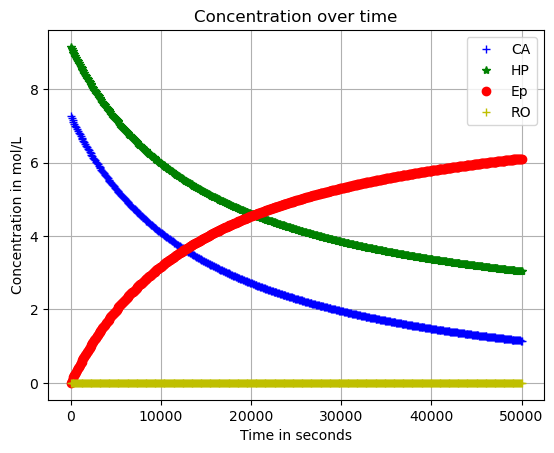

In [19]:
# Plot results
plt.figure(1)
plt.title("Concentration over time")
plt.plot(t, CA_1, 'b+', label='CA')
plt.plot(t, HP_1, 'g*', label='HP')
plt.plot(t, Ep_1, 'ro', label='Ep')
plt.plot(t, RO_1, 'y+', label='RO')
plt.grid(True) 
plt.xlabel("Time in seconds")
plt.ylabel("Concentration in mol/L")
plt.legend(loc='upper right')
plt.show()

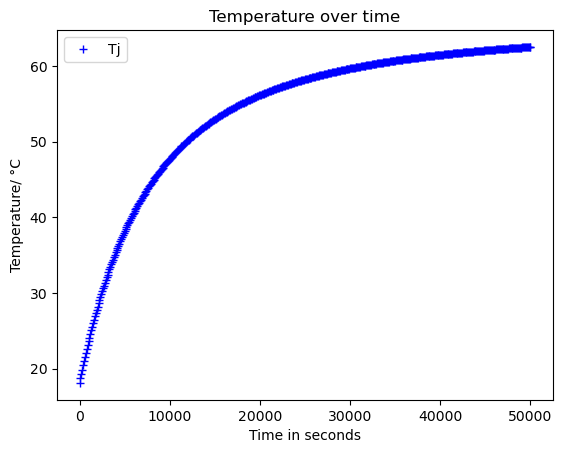

In [20]:
plt.figure(2)
plt.plot(t, Tj, 'b+', label='Tj')
plt.title("Temperature over time")
plt.xlabel("Time in seconds")
plt.ylabel("Temperature/ °C")
plt.legend()
plt.show()

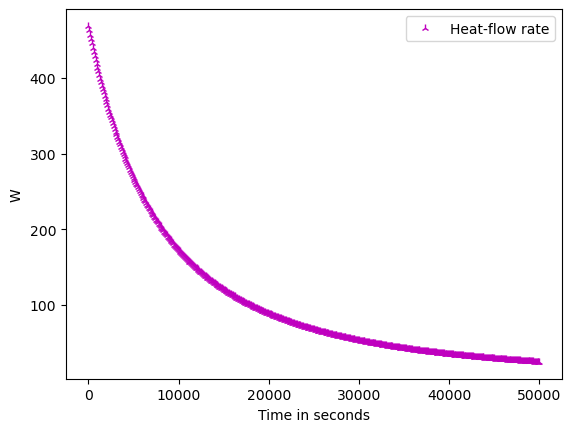

In [21]:
plt.figure(3)
plt.plot(t, qrx, 'm2', label='Heat-flow rate')
plt.xlabel("Time in seconds")
plt.ylabel("W")
plt.legend()
plt.show()